# Initializing CellTRIP

First, import all necessary libraries and set any environment variables.

In [1]:
import io
import logging
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import umap

import celltrip

# No verbose cred grab
logging.getLogger('aiobotocore').setLevel(logging.CRITICAL)
logging.getLogger('fsspec').setLevel(logging.CRITICAL)

# Environment and styling
# os.environ['AWS_PROFILE'] = 'user'  # If AWS creds are needed, change this to your AWS profile name
mpl.rcParams['pdf.fonttype'] = mpl.rcParams['ps.fonttype'] = 42  # Make figure text editable
sns.set_theme(context='paper', style='dark', palette='colorblind')  # Style figures


Then, load the data using the `celltrip.utility.processing.read_adatas` function.

In [2]:
# Read data files
adatas = celltrip.utility.processing.read_adatas(
    's3://nkalafut-celltrip/dyngen/logcounts.h5ad',
    's3://nkalafut-celltrip/dyngen/counts_protein.h5ad',
    backed=True)


More complicated file layouts might require using the `celltrip.utility.processing.merge_adatas` function, which concatenates `adata` objects along the sample dimension, automatically inferring common features.

In [3]:
# adata = celltrip.utility.processing.merge_adatas(adata_counts_1, adata_counts_2)

There are three types of files with each CellTRIP model:
- The preprocessing class, `.pre`,
- The training mask, `.mask`,
- and the model weights, `.weights`.

The preprocessing and mask files can be loaded first from s3 or local.

In [4]:
# Load preprocessing
preprocessing = celltrip.utility.processing.Preprocessing().load(f's3://nkalafut-celltrip/checkpoints/Dyngen-251015.pre')

# Load mask
with celltrip.utility.general.open_s3_or_local(f's3://nkalafut-celltrip/checkpoints/Dyngen-251015.mask', 'rb') as f:
    mask = np.loadtxt(f).astype(bool)

We can now choose our input data and initialize the environment. Note that the order of modalities is important.

In [5]:
# Subset and preprocess the data (Use partition cols here to select data)
samples = adatas[0].obs.index
# More advanced sample selection can also be performed if desired
# samples = adatas[0].obs.loc[adatas[0].obs[SOME_FEATURE] == SOME_STAGE].index

# Preprocess the data
m1, m2 = preprocessing.transform([ad[samples].X for ad in adatas])
# If your system is low on memory or the dataset is particularly large, you can use the utility
# function below to transform the data in chunks of size `chunk_size`
# m1, m2 = [
#     celltrip.utility.processing.chunk_X(
#         ad[samples], chunk_size=2_000,
#         func=lambda x: preprocessing.transform(x, subset_modality=i)[0])
#         for i, ad in enumerate(adatas)]

# Initialize environment
env = celltrip.environment.EnvironmentBase(
    torch.tensor(m1), torch.tensor(m2), target_modalities=None, dim=32).eval().to('cuda')

For imputation applications, the `target_modalities` argument should be set to an array containing the indices of modalities to impute.
So, if the second modality was imputed, we might do the following:

In [6]:
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), torch.tensor(m2), target_modalities=[1], dim=32).eval().to('cuda')

If we are missing the modality to impute, we can instead leave `target_modalities=None` and disable reward computation.

In [7]:
# env = celltrip.environment.EnvironmentBase(
#     torch.tensor(m1), target_modalities=None, dim=32).disable_rewards().eval().to('cuda')

If we need to change the modalities at any point, we can do so using the `set_modalities` function.

In [8]:
# env.set_modalities([torch.tensor(m3), torch.tensor(m4)]).to('cuda')

Finally, we can load the model.

In [9]:
policy = celltrip.policy.create_agent_from_env(env).eval().to('cuda')
policy.load_checkpoint(f's3://nkalafut-celltrip/checkpoints/Dyngen-251015-0800.weights');  # If the model slightly differs in architecture, you may also pass in `strict=False` to avoid loading errors

If the model deals with spatial (or translationally invariant) modalities, the additional `pinning_spatial` parameter should be set to an array of the indices of spatial modalities.

In [10]:
# policy = celltrip.policy.create_agent_from_env(env, pinning_spatial=[1]).eval().to('cuda')

If the environment is missing modalities, the `pinning_modal_dims` parameter must also be supplied.

In [11]:
# policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[N_FEATS]).eval().to('cuda')
# If some of the pinning modalities are spatial, note that the `pinning_spatial` parameter now
# only considers the indices of TARGET modalities. So, the above may be changed as follows for 
# single-modal imputation to a 3D spatial modality (e.g. gex -> spatial)
# policy = celltrip.policy.create_agent_from_env(env, pinning_modal_dims=[3], pinning_spatial=[0]).eval().to('cuda')

Several arguments can also be added to modify the behavior of the model, particularly with regards to memory usage.

In [12]:
# policy = celltrip.policy.create_agent_from_env(env,
#     forward_batch_size=1_000,   # Set maximum number of nodes processed at once, mainly for VRAM concerns
#     vision_size=1_000           # Set maximum number of nodes to consider while computing attention, can affect model performance
# ).eval().to('cuda')

# Basic Analysis

The main function for analysis is `celltrip.train.simulate_until_completion`. This function will run an environment until completion.
The `store_states` argument will return a 3-dimensional tensor `(timestep, cell, position+velocity)` of the environment progression.

In [13]:
env.reset()  # Random initialization of the environment
num_timesteps, num_memories, reward, itemized_reward, states = celltrip.train.simulate_until_completion(env, policy, store_states=True)
steady_state = states[-1]  # We call the space of the final simulated state from random initialization (-1) the steady state
steady_pos = steady_state[..., :env.dim]  # Remove velocities for analysis
print(f'Total Reward: {reward:.3f} (Pinning: {itemized_reward["pinning"]:.3f}, Velocity: {itemized_reward["velocity"]:.3f}, Action: {itemized_reward["action"]:.3f})')

Total Reward: 1.649 (Pinning: 0.862, Velocity: 0.797, Action: -0.009)


In the case that simulation states are too large or too numerous to store in VRAM, `store_states='cpu'` will cast all stored tensors to RAM. Additionally, `skip_states` can be utilized to only store one in every `skip_states` environment states.

In [14]:
# celltrip.train.simulate_until_completion(
#     env, policy,
#     skip_states=100,  # Only store 1/100 intermediate states, but always include first and last
#     store_states='cpu')  # Store states on CPU rather than GPU

We can then translate from the latent space to feature space using the `policy.pinning` modules.

In [15]:
m1_pred = policy.pinning[0](steady_pos).detach().cpu().numpy()
m2_pred = policy.pinning[1](steady_pos).detach().cpu().numpy()
print(f'Modality 1 Standardized MSE: {np.square(m1_pred - m1).mean():.3f}\nModality 2 Standardized MSE: {np.square(m2_pred - m2).mean():.3f}')

Modality 1 Standardized MSE: 3.328
Modality 2 Standardized MSE: 2.333


If imputing to a spatial modality and the true features are known, CellTRIP can automatically translate and rotate the pinned output to match. This can also be performed manually.

In [16]:
# # Automatic
# m1_pred = policy.pinning[0](steady_pos, torch.tensor(m1, device='cuda')).detach().cpu().numpy()

# # Manual
# R, t = celltrip.utility.processing.solve_rot_trans(steady_pos, torch.tensor(m1, device='cuda'))
# m1_pred = celltrip.utility.processing.apply_rot_trans(steady_pos, R, t)

We can also reverse any standardization or PCA applied by the preprocessing class.

In [17]:
m1_pred_inverse, = preprocessing.inverse_transform(m1_pred, subset_modality=0)
m2_pred_inverse, = preprocessing.inverse_transform(m2_pred, subset_modality=1)
print(f'Modality 1 Raw MSE: {np.square(m1_pred_inverse - adatas[0][samples].X).mean():.3f}\nModality 2 Raw MSE: {np.square(m2_pred_inverse - adatas[1][samples].X).mean():.3f}')

Modality 1 Raw MSE: 0.147
Modality 2 Raw MSE: 60692595.922


Finally, we can visualize our results

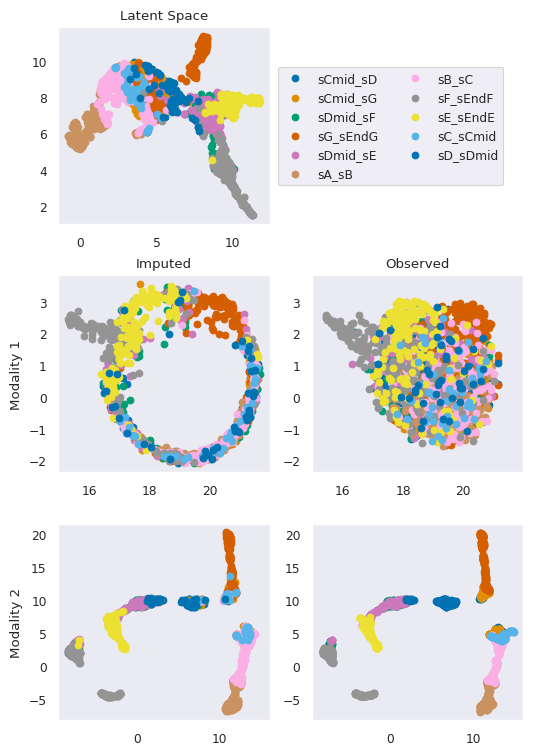

In [18]:
fig = plt.figure(figsize=(1.5*4, 1.5*6))
fig.subplots_adjust(wspace=.5, hspace=.7)
cell_types = adatas[0].obs['traj_sim']

# Latent space
ax = plt.subplot2grid((6, 4), (0, 0), 2, 2, fig)
reduced = umap.UMAP(n_jobs=1, random_state=42).fit_transform(steady_pos.cpu())
for ct in cell_types.unique():
    ax.scatter(*reduced[cell_types==ct].T, label=ct)
# Shrink axis and put legend in whitespace (https://stackoverflow.com/a/4701285)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width*(1/2), box.height])
ax.legend(ncols=2, loc='center left', bbox_to_anchor=(1.04, 0.5), borderaxespad=0)
ax.set(title='Latent Space')

# Modality 1 observed
ax = plt.subplot2grid((6, 4), (2, 2), 2, 2, fig)
reducer = umap.UMAP(n_jobs=1, random_state=42)
reduced = reducer.fit_transform(adatas[0][samples].X)
for ct in cell_types.unique():
    ax.scatter(*reduced[cell_types==ct].T, label=ct)
ax.set(title='Observed')

# Modality 1 imputed
ax = plt.subplot2grid((6, 4), (2, 0), 2, 2, fig, sharex=ax, sharey=ax)
reduced = reducer.transform(m1_pred_inverse)
for ct in cell_types.unique():
    ax.scatter(*reduced[cell_types==ct].T, label=ct)
ax.set(title='Imputed', ylabel='Modality 1')

# Modality 2 observed
ax = plt.subplot2grid((6, 4), (4, 2), 2, 2, fig)
reducer = umap.UMAP(n_jobs=1, random_state=42)
reduced = reducer.fit_transform(adatas[1][samples].X)
for ct in cell_types.unique():
    ax.scatter(*reduced[cell_types==ct].T, label=ct)

# Modality 2 imputed
ax = plt.subplot2grid((6, 4), (4, 0), 2, 2, fig, sharex=ax, sharey=ax)
reduced = reducer.transform(m2_pred_inverse)
for ct in cell_types.unique():
    ax.scatter(*reduced[cell_types==ct].T, label=ct)
ax.set(ylabel='Modality 2');

# Hooks

While simulating, additional `hooks` may be added to alter or perturb the simulation. These are typically used when perturbing from the steady state to a perturbed state.

In [19]:
# celltrip.train.simulate_until_completion(
#     ...,
#     env_hooks=[
#         # Set `feature_idx` features in `modality` to `feature_targets` before preprocessing...
#         celltrip.utility.hooks.clamp_input_features_hook(
#             feature_idx, self.preprocessing, feature_targets=[0, 1, ...],
#             modality_idx=0, device=self.device),
#         # Or after preprocessing...
#         celltrip.utility.hooks.clamp_input_features_hook(
#             feature_idx, self.preprocessing, feature_targets=[0, 1, ...],
#             modality_idx=1),
#     ],
#     action_hooks=[
#         # Or use gradient descent to move toward the target value in the environment space
#         celltrip.utility.hooks.move_toward_targets_hook(
#             feature_idx, self.preprocessing, feature_targets=feature_targets,
#             pinning=self.policy.pinning[modality], modality_idx=modality,
#             factor=factor, device=self.device)
#     ])

The `feature_targets` of any hook can be changed over time using the `continuous_feature_targets` hook. The `continuous_feature_targets` hook takes another hook as the first argument, a function for converting simulation time to feature targets as the second, and other hook arguments beyond that. An example is shown below.

In [20]:
# celltrip.utility.hooks.continuous_feature_targets(
#     celltrip.utility.hooks.move_toward_targets_hook,
#     lambda time: 10 - time / env.max_time,  # Linearly interpolate from 10 to 0, can also output an array
#     feature_idx, pinning=policy.pinning[0],
#     preprocessing=preprocessing, modality_idx=0,
#     factor=1., device=env.device)

# Dynamic Analysis

For examples of more specialized analyses, including developmental stage recovery, please explore other notebooks and source code, including the `tutorial_high_level.ipynb` notebook and `manager.py` module.